In [1]:
import torch
import crbm
import rbm
import h5py

# CHOOSE CPU OR GPU
# device = torch.device("cpu") 
device = torch.device("cuda:1")
dtype = torch.float

# Load DATASET
import numpy as np
import matplotlib.pyplot as plt

path_dset = '../../TorchRBM.py/dataset/'
# randomize the dataset
X = torch.tensor(np.genfromtxt(path_dset+'10K_SNP_1000G_real.hapt')[:,2:].T).float().to(device)
X = X[:,torch.randperm(X.shape[1])]

Nv = X.shape[0]
Ns = X.shape[1]
print('NumSamples=',Ns)
print('ShapeX : ',X.shape)

NumSamples= 5008
ShapeX :  torch.Size([10000, 5008])


In [2]:
# Some scatter plots of the dataset
u,s,v = torch.svd(X)
ScatX = (X.T @ u).cpu()

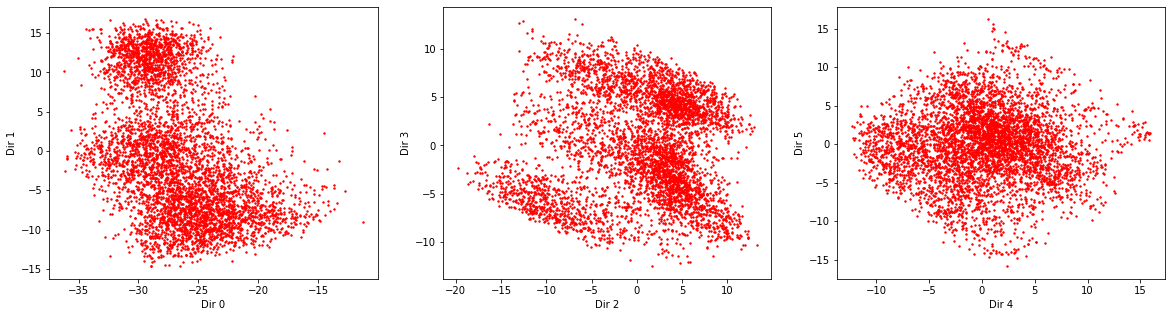

In [3]:
# Scatter plots on the first 6 directions
fig,ax = plt.subplots(1,3,figsize=(20,5))
for i in range(3):
    ax[i].scatter(ScatX[:,2*i],ScatX[:,2*i+1],s=2,color='red')
    ax[i].set_xlabel('Dir '+str(2*i))
    ax[i].set_ylabel('Dir '+str(2*i+1))

### Generating the first 5000 variables using another RBM

In [4]:
path = '../OOERBM/'
fname_gen = path+'RBMTrainingGene10K_OOELearning_Nh2000_lr0.001_l20.0_Rdm_NGibbs50.h5'
f_gen = h5py.File(fname_gen,'r')
Nh = f_gen['Nh'][()]
Nv = f_gen['Nv'][()]
l2 = f_gen['l2'][()]
NGibbs = f_gen['NGibbs'][()]
print(Nv,' ',Nh)

10000   2000


In [5]:
# Creating Object RBM
RBMGene = rbm.RBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				regL2=l2,
				gibbs_steps=NGibbs,
				UpdCentered=True)

In [6]:
# Loading the last epoch
ep_last = f_gen['alltime'][:][-1]
print('Ep=',ep_last)
RBMGene.W = torch.tensor(f_gen['W_'+str(ep_last)][:]).to(device)
RBMGene.vbias = torch.tensor(f_gen['vbias_'+str(ep_last)][:]).to(device)
RBMGene.hbias = torch.tensor(f_gen['hbias_'+str(ep_last)][:]).to(device)

Ep= 100001


In [7]:
# Generate new samples
NS = 1000
NGibbs_GEN = 200
vinit = torch.bernoulli(torch.rand((Nv,NS), device=RBMGene.device, dtype=RBMGene.dtype))
vs,vm,_,_ = RBMGene.Sampling(vinit,it_mcmc=50)

In [8]:
AG_Scat = (vs.T @ u).cpu()

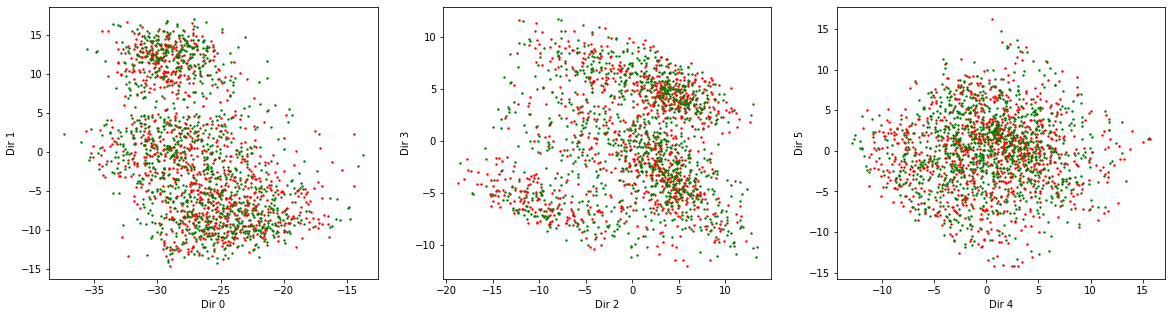

In [9]:
# Scatter plots on the first 6 directions
fig,ax = plt.subplots(1,3,figsize=(20,5))
for i in range(3):
    ax[i].scatter(ScatX[:NS,2*i],ScatX[:NS,2*i+1],s=2,color='red')
    ax[i].scatter(AG_Scat[:,2*i],AG_Scat[:,2*i+1],s=2,color='green')
    ax[i].set_xlabel('Dir '+str(2*i))
    ax[i].set_ylabel('Dir '+str(2*i+1))

In [11]:
Xseed = vs.clone()

### Investigating the behavior of the RBM at various epochs

In [12]:
fname = 'RBMTrainingGene10K_5KP1_CDT_OOELearning_Nh2000_lr0.001_l20.0_Rdm_NGibbs50.h5'
f = h5py.File(fname,'r')
Nh = f['Nh'][()]
Nv = f['Nv'][()]
l2 = f['l2'][()]
NGibbs = f['NGibbs'][()]

In [13]:
# Creating Object RBM
RBMGene = crbm.CRBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				regL2=l2,
				gibbs_steps=NGibbs,
				UpdCentered=True)

In [14]:
# Loading the last epoch
ep_last = f['alltime'][:][-1]
print('Ep=',ep_last)
RBMGene.W = torch.tensor(f['W_'+str(ep_last)][:]).to(device)
RBMGene.vbias = torch.tensor(f['vbias_'+str(ep_last)][:]).to(device)
RBMGene.hbias = torch.tensor(f['hbias_'+str(ep_last)][:]).to(device)

Ep= 20001


In [20]:
# Generate new samples
NS = 1000
idx_perm = torch.randperm(NS)
vinit = torch.bernoulli(torch.rand((Nv,NS), device=RBMGene.device, dtype=RBMGene.dtype))
vinit[:5000,:] = Xseed[:5000,idx_perm[:NS]]
vs,vm,_,_ = RBMGene.Sampling(vinit,it_mcmc=20000) #NGibbs)

In [21]:
print((vinit[:5000,:] - Xseed[:5000,idx_perm[:NS]]).sum())

tensor(0., device='cuda:1')


In [22]:
AG_Scat = (vs.T @ u).cpu()

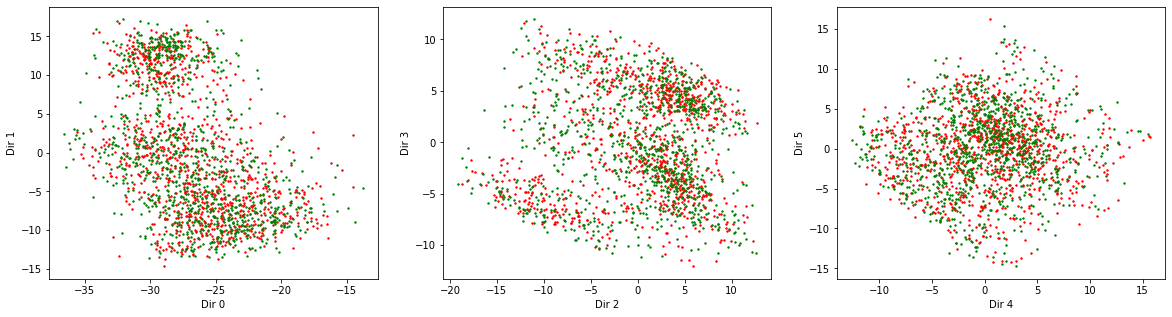

In [23]:
# Scatter plots on the first 6 directions
fig,ax = plt.subplots(1,3,figsize=(20,5))
for i in range(3):
    ax[i].scatter(ScatX[:NS,2*i],ScatX[:NS,2*i+1],s=2,color='red')
    ax[i].scatter(AG_Scat[:,2*i],AG_Scat[:,2*i+1],s=2,color='green')
    ax[i].set_xlabel('Dir '+str(2*i))
    ax[i].set_ylabel('Dir '+str(2*i+1))

In [24]:
# Check AATS in time

TMax = 20000
Δt = 10
Nmsr = TMax//Δt+1
AATS_MCMC = torch.zeros(Nmsr,2)
T_TOT = 0

vs = torch.bernoulli(torch.rand((Nv,NS), device=RBMGene.device, dtype=RBMGene.dtype))
vs[:5000,:] = Xseed[:5000,idx_perm[:NS]]

idx_t = 0
AATS_MCMC[idx_t,0],AATS_MCMC[idx_t,1] = RBMGene.ComputeAATS(Xseed[5000:,torch.randperm(Xseed.size()[1])[:NS]],vs[5000:,:],NS)

while(T_TOT<TMax):
    vs,vm,_,_ = RBMGene.Sampling(vs,it_mcmc=Δt)
    idx_t += 1
    T_TOT += Δt
    AATS_MCMC[idx_t,0],AATS_MCMC[idx_t,1] = RBMGene.ComputeAATS(Xseed[5000:,:NS],vs[5000:,:],NS)

<ipython-input-25-39c1c7d6fe50>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_xlim(0,TMax)


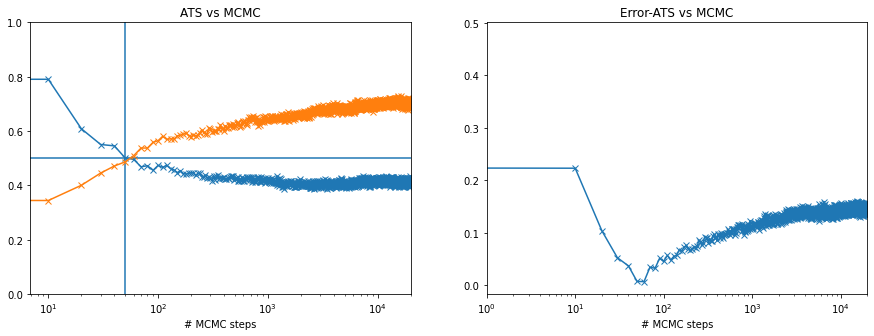

In [25]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].semilogx(np.arange(0,TMax+1,Δt),AATS_MCMC,'x-')
ax[0].vlines(50,0,1)
ax[0].hlines(0.5,0,TMax)
ax[0].set_xlim(0,TMax)
ax[1].set_xlim(1,TMax)
ax[0].set_ylim(0,1)
ax[0].set_title('ATS vs MCMC')
ax[0].set_xlabel('# MCMC steps')
ax[1].set_title('Error-ATS vs MCMC')
ax[1].set_xlabel('# MCMC steps')
ax[1].semilogx(np.arange(0,TMax+1,Δt),0.5*np.abs(AATS_MCMC-0.5).sum(1),'x-')

### Evaluation of the model during learning
1. Using the number of MC steps that is optimal (OOE learning)

In [83]:
# Eigenvalues and AATS (@NGibbs)
NEp = f['alltime'].shape[0]


# sublist to not use all epochs
sublist_time = f['alltime'][:]
idx_ep = []
for i in sublist_time:
    idx_ep.append(np.where(f['alltime'][:] == i)[0][0])
idx_ep = np.array(idx_ep)
NEp = idx_ep.shape[0]

eigens = torch.zeros(NEp,min(100,Nh))
LIKE = torch.zeros(NEp)
AATS = torch.zeros(NEp,2)
AATS_seed = torch.zeros(NEp,2)

# Choose NGibbs=35
NGibbs_GEN = 50

for i in np.arange(NEp):
    iep = idx_ep[i]
    ep = f['alltime'][:][iep]

    RBMGene.W = torch.tensor(f['W_'+str(ep)][:]).to(device)
    RBMGene.vbias = torch.tensor(f['vbias_'+str(ep)][:]).to(device)
    RBMGene.hbias = torch.tensor(f['hbias_'+str(ep)][:]).to(device)
    
    # Compute eigenvalues
    _,s,_ = torch.svd(RBMGene.W)
    eigens[i,:] = s[:100].cpu()
    
    # Generate samples
    vinit = torch.bernoulli(torch.rand((Nv,NS), device=RBMGene.device, dtype=RBMGene.dtype))
    vinit[:5000,:] = Xseed[:5000,idx_perm[:NS]]
    vs,vm,_,_ = RBMGene.Sampling(vinit,it_mcmc=NGibbs_GEN)
    
    # Compute AATS
    AATS_seed[i,0],AATS_seed[i,1] = RBMGene.ComputeAATS(Xseed[5000:,torch.randperm(Xseed.size()[1])[:NS]],vs[5000:,:],NS)
    AATS[i,0],AATS[i,1] = RBMGene.ComputeAATS(X[5000:,torch.randperm(X.size()[1])[:NS]],vs[5000:,:],NS)
    
    # Compute Likelihood
    FreeEnergyLIKE = -torch.mean(RBMGene.FreeEnergy(X))
    LIKE[i] = FreeEnergyLIKE-f['FE_AIS_'+str(ep)][()]*(Nv+Nh)

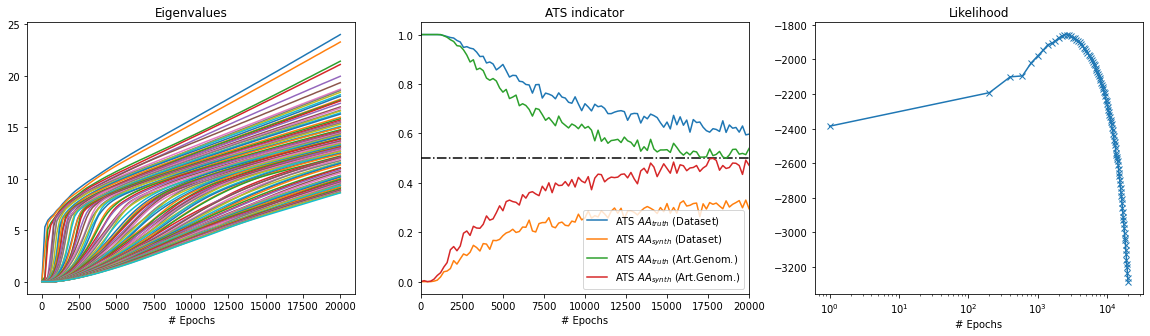

In [84]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax[0].plot(sublist_time,eigens);

pl_Ats1, pl_Ats2 = ax[1].plot(sublist_time,AATS) #,label=['ATS to Art.Gen.','ATS to Art.Gen.1']);
pl_Ats1_SEED, pl_Ats2_SEED = ax[1].plot(sublist_time,AATS_seed) #,label='ATS to Dataset');
ax[1].legend([pl_Ats1,pl_Ats2,pl_Ats1_SEED,pl_Ats2_SEED],
             [r'ATS $AA_{truth}$ (Dataset)',r'ATS $AA_{synth}$ (Dataset)',
              r'ATS $AA_{truth}$ (Art.Genom.)',r'ATS $AA_{synth}$ (Art.Genom.)'],
             loc='lower right')
ax[1].hlines(0.5,0,sublist_time[-1],color='black',ls='-.')
ax[1].set_xlim(0,sublist_time[-1])

ax[2].semilogx(sublist_time,LIKE,'x-')

ax[0].set_title('Eigenvalues')
ax[1].set_title('ATS indicator')
ax[2].set_title('Likelihood')
for i in range(3):
    ax[i].set_xlabel('# Epochs')

2. Using a very large number of MC steps

In [58]:
# Eigenvalues and AATS (@NGibbs)
NEp = f['alltime'].shape[0]


# sublist to not use all epochs
sublist_time = f['alltime'][::10]
idx_ep = []
for i in sublist_time:
    idx_ep.append(np.where(f['alltime'][:] == i)[0][0])
idx_ep = np.array(idx_ep)
NEp = idx_ep.shape[0]

eigens = torch.zeros(NEp,min(100,Nh))
LIKE = torch.zeros(NEp)
AATS = torch.zeros(NEp,2)
AATS_seed = torch.zeros(NEp,2)

# Choose NGibbs=35
NGibbs_GEN = 20000

for i in np.arange(NEp):
    iep = idx_ep[i]
    ep = f['alltime'][:][iep]

    RBMGene.W = torch.tensor(f['W_'+str(ep)][:]).to(device)
    RBMGene.vbias = torch.tensor(f['vbias_'+str(ep)][:]).to(device)
    RBMGene.hbias = torch.tensor(f['hbias_'+str(ep)][:]).to(device)
    
    # Compute eigenvalues
    _,s,_ = torch.svd(RBMGene.W)
    eigens[i,:] = s[:100].cpu()
    
    # Generate samples
    vinit = torch.bernoulli(torch.rand((Nv,NS), device=RBMGene.device, dtype=RBMGene.dtype))
    vinit[:5000,:] = Xseed[:5000,idx_perm[:NS]]
    vs,vm,_,_ = RBMGene.Sampling(vinit,it_mcmc=NGibbs_GEN)
    
    # Compute AATS
    AATS_seed[i,0],AATS_seed[i,1] = RBMGene.ComputeAATS(Xseed[5000:,torch.randperm(Xseed.size()[1])[:NS]],vs[5000:,:],NS)
    AATS[i,0],AATS[i,1] = RBMGene.ComputeAATS(X[5000:,torch.randperm(X.size()[1])[:NS]],vs[5000:,:],NS)
    
    # Compute Likelihood
    FreeEnergyLIKE = -torch.mean(RBMGene.FreeEnergy(X))
    LIKE[i] = FreeEnergyLIKE-f['FE_AIS_'+str(ep)][()]*(Nv+Nh)

In [ ]:
[b,c,d,e] = plot(a)
legend([b,c,d,e], ["b","c","d","e"], loc=1)

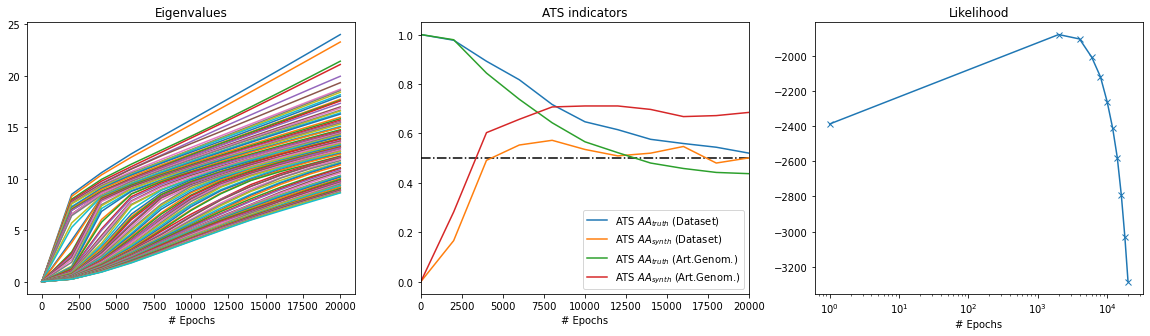

In [81]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax[0].plot(sublist_time,eigens);
pl_Ats1, pl_Ats2 = ax[1].plot(sublist_time,AATS) #,label=['ATS to Art.Gen.','ATS to Art.Gen.1']);
pl_Ats1_SEED, pl_Ats2_SEED = ax[1].plot(sublist_time,AATS_seed) #,label='ATS to Dataset');

ax[1].legend([pl_Ats1,pl_Ats2,pl_Ats1_SEED,pl_Ats2_SEED],
             [r'ATS $AA_{truth}$ (Dataset)',r'ATS $AA_{synth}$ (Dataset)',
              r'ATS $AA_{truth}$ (Art.Genom.)',r'ATS $AA_{synth}$ (Art.Genom.)'],
             loc='lower right')

ax[1].hlines(0.5,0,sublist_time[-1],color='black',ls='-.')
ax[1].set_xlim(0,sublist_time[-1])
ax[2].semilogx(sublist_time,LIKE,'x-')

ax[0].set_title('Eigenvalues')
ax[1].set_title('ATS indicators')
ax[2].set_title('Likelihood')
for i in range(3):
    ax[i].set_xlabel('# Epochs')

